# Clasificación de generos musicales con Deep Learning

Dataset for Music Analysis

FMA(Free Music Archive) 
https://github.com/mdeff/fma

# Analisis y procesamiento de ondas de sonido

In [1]:
import os
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:

AUDIO_DIR = '/Users/andresmanzalini/Documents/Datasets/FMA/fma_small'
DATA_DIR = '/Users/andresmanzalini/Documents/Datasets/FMA/fma_metadata'

LONG_SPECTO = 640 
BINS = 128 

In [3]:
def get_tids_from_directory(audio_dir):
    tids = []
    for _, dirnames, files in os.walk(audio_dir):
        if dirnames == []:
            tids.extend(int(file[:-4]) for file in files if file !='.DS_Store')
    return tids


def get_audio_path(audio_dir, track_id):
    tid_str = '{:06d}'.format(track_id)
    return os.path.join(audio_dir, tid_str[:3], tid_str + '.mp3')


In [4]:
tids = get_tids_from_directory(AUDIO_DIR)
print(len(tids))

8000


In [5]:
def filtrar_por_size(tids,min_size=350000): #corto a partir de 350 para abajo
    tids_correctos = []
    for file in tids:
        fpath = get_audio_path(AUDIO_DIR, file)
        tam = os.path.getsize(fpath)
        #print('file: ', filepath)
        #print('size: ',tam)
        if tam > min_size:
            tids_correctos.append(file)
        else:
            print('INCORRECTO ', file)
    tids_ok = np.array(tids_correctos, dtype='int64')
    print('Tracks correctos ', tids_ok.size)
    return tids_ok

In [6]:
tracks_correctos = filtrar_por_size(tids)

INCORRECTO  133297
INCORRECTO  98565
INCORRECTO  98567
INCORRECTO  98569
INCORRECTO  99134
INCORRECTO  108925
Tracks correctos  7994


# Metadata con pandas

In [7]:
filepath = DATA_DIR+'/tracks.csv'
tracks = pd.read_csv(filepath, index_col=0, header=[0, 1])

#selecciono columnas del dataframe 
cols = [('set', 'split'),('set', 'subset'),('track', 'genre_top')]

#filtro por columnas
df_small = tracks[cols]
df_small = df_small[df_small[('set', 'subset')] == 'small'] 

#filtro por los tracks que superan cierto tamano
df_filtrado = df_small[df_small.index.isin(tracks_correctos)]

In [8]:
df_filtrado.head(10)
#tracks.head()

set                track
               split subset     genre_top
track_id                                 
2           training  small       Hip-Hop
5           training  small       Hip-Hop
10          training  small           Pop
140         training  small          Folk
141         training  small          Folk
148       validation  small  Experimental
182             test  small          Rock
190         training  small          Folk
193         training  small          Folk
194         training  small          Folk

In [9]:
df_filtrado[('track', 'genre_top')].unique()


array(['Hip-Hop', 'Pop', 'Folk', 'Experimental', 'Rock', 'International',
       'Electronic', 'Instrumental'], dtype=object)

In [10]:
dict_genres = {'Electronic':1, 'Experimental':2, 'Folk':3, 'Hip-Hop':4, 
               'Instrumental':5,'International':6, 'Pop' :7, 'Rock': 8  }

In [11]:
df_train = df_filtrado[df_filtrado[('set', 'split')] == 'training']
df_valid = df_filtrado[df_filtrado[('set', 'split')] == 'validation']
df_test = df_filtrado[df_filtrado[('set', 'split')] == 'test']

print(df_train.shape, df_valid.shape, df_test.shape)

df_train.head()

(6394, 3) (800, 3) (800, 3)


set            track
             split subset genre_top
track_id                           
2         training  small   Hip-Hop
5         training  small   Hip-Hop
10        training  small       Pop
140       training  small      Folk
141       training  small      Folk

In [12]:
df_test.index

Int64Index([   182,    704,    705,    706,    707,    708,    709,    890,
               892,   1066,
            ...
            150017, 150018, 150287, 150288, 154303, 154305, 154306, 154307,
            154308, 154309],
           dtype='int64', name='track_id', length=800)

# Audio con librosa/ffmpeg

In [13]:
#funcion para crear espectrogramas con librosa
#comparar eficiencia entre librosa y ffmpeg!

def create_spectrogram(track_id):
    try:
        filename = get_audio_path(AUDIO_DIR, track_id)
        #print('file ', track_id)
        y, sr = librosa.load(filename)
        spect = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=2048, hop_length=1024)
        spect = librosa.power_to_db(spect, ref=np.max)
        #print('salida del spectro.T ', spect.T[:2,:].shape)
        return spect.T
    except:
        print('ERROR al procesar ', track_id)
        pass

In [14]:
import subprocess as sp

def create_spectrogram_ffmpeg(track_id):
    filepath = get_audio_path(AUDIO_DIR, track_id)

    command = ['ffmpeg','-i', filepath, '-f', 's16le', '-acodec', 'pcm_s16le', '-ac', '1'] # channels 2 for stereo, 1 for mono
    command.append('-')
    # 30s at 44.1 kHz ~= 1.3e6
    try:
        proc = sp.run(command, stdout=sp.PIPE, bufsize=10**7, stderr=sp.DEVNULL, check=True)
        res = np.fromstring(proc.stdout, dtype="int16")
        print('res de fmpegloader ', res) #A VECES SE CEBA
        return res
    except sp.CalledProcessError as e:
        print('FLASHASTE con ',filepath)
        pass


In [15]:
def plot_spect(track_id):
    spect = create_spectrogram(track_id)
    plt.figure(figsize=(10, 4))
    librosa.display.specshow(spect.T, y_axis='mel', fmax=8000, x_axis='time')
    plt.colorbar(format='%+2.0f dB')
    plt.show()
    #plt.imsave('prueba', spect)

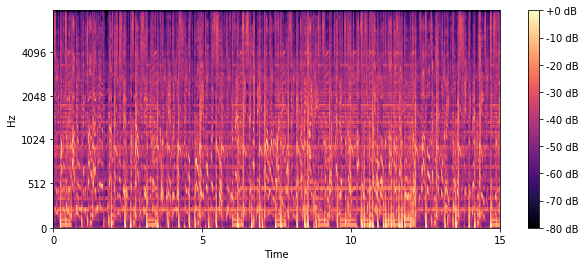

img (646, 128)


In [16]:
# ejemplo con tid = 2
plot_spect(2)
img = np.array(create_spectrogram(2))
#plt.imsave('spectrograma.jpg',plot_spect(2))
print('img',img.shape)

(646, 128)


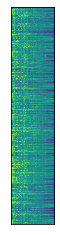

In [17]:
import numpy as np
import cv2
from matplotlib import pyplot as plt

print(img.shape)
plt.imshow(img)#, cmap = 'gray', interpolation = 'bicubic')
plt.xticks([]), plt.yticks([])  # to hide tick values on X and Y axis
plt.show()


# GENERADOR

# MMF - Archivos mapeados en memoria

Archivos mapeados a memoria.

A diferencia del generador que hereda de Sequential, en el sgte script acumula carga computacional.
Paralelismo limitado por memoria virtual


In [18]:
import keras
#dependiendo de los tamanos de la ram y del dataset, esta forma de entrenar te come la memoria.
dict_genres = {'Electronic':1, 'Experimental':2, 'Folk':3, 'Hip-Hop':4, 
               'Instrumental':5,'International':6, 'Pop' :7, 'Rock': 8  }

list_gen = list(dict_genres.values())
np_gen = np.array(list_gen)
CANT_GENEROS = np_gen.shape[0]
CANT_GENEROS
#EJECUTAR UNA SOLA VEZ para cargar los datos a archivos mapeados a memoria en formato .dat

Using TensorFlow backend.


8

In [26]:
from tqdm import tqdm

#Creo el arreglo numpy en un archivo mapeado a memoria
npData_x_train = np.memmap('x_train.dat', dtype='float32', mode='w+', shape=(len(df_train), LONG_SPECTO, BINS))
npData_y_train = np.memmap('y_train.dat', dtype='float32', mode='w+', shape=(len(df_train), CANT_GENEROS))

npData_x_valid = np.memmap('x_valid.dat', dtype='float32', mode='w+', shape=(len(df_valid), LONG_SPECTO, BINS))
npData_y_valid = np.memmap('y_valid.dat', dtype='float32', mode='w+', shape=(len(df_valid), CANT_GENEROS))

npData_x_test = np.memmap('x_test.dat', dtype='float32', mode='w+', shape=(len(df_test), LONG_SPECTO, BINS))
npData_y_test = np.memmap('y_test.dat', dtype='float32', mode='w+', shape=(len(df_test), CANT_GENEROS))

#Proceso los datos
for i, track_id in tqdm(enumerate(df_train.index), total=len(df_train)): 
    npData_x_train[i, :, :] = create_spectrogram(track_id)[:LONG_SPECTO, :]
    genero = df_train[('track','genre_top')].loc[track_id]
    int_genero = dict_genres.get(genero)
    y_categ = keras.utils.np_utils.to_categorical(int_genero-1, CANT_GENEROS) #-1 normaliza np con diccionario
    npData_y_train[i,:] = y_categ
    
    
for i, track_id in tqdm(enumerate(df_valid.index), total=len(df_valid)): 
    npData_x_valid[i, :, :] = create_spectrogram(track_id)[:LONG_SPECTO, :]
    genero = df_valid[('track','genre_top')].loc[track_id]
    int_genero = dict_genres.get(genero)
    y_categ = keras.utils.np_utils.to_categorical(int_genero-1, CANT_GENEROS)
    npData_y_valid[i,:] = y_categ
    
    
for i, track_id in tqdm(enumerate(df_test.index), total=len(df_test)): 
    npData_x_test[i, :, :] = create_spectrogram(track_id)[:LONG_SPECTO, :]
    genero = df_test[('track','genre_top')].loc[track_id]
    int_genero = dict_genres.get(genero)
    y_categ = keras.utils.np_utils.to_categorical(int_genero-1, CANT_GENEROS)
    npData_y_test[i,:] = y_categ
    

del npData_x_train
del npData_y_train
del npData_x_valid
del npData_y_valid
del npData_x_test
del npData_y_test




  0%|          | 0/6394 [00:00<?, ?it/s]


  0%|          | 1/6394 [00:01<2:13:57,  1.26s/it]

Hip-Hop
4
[0. 0. 0. 1. 0. 0. 0. 0.]





  0%|          | 2/6394 [00:02<2:13:18,  1.25s/it]

Hip-Hop
4
[0. 0. 0. 1. 0. 0. 0. 0.]





  0%|          | 3/6394 [00:03<2:11:51,  1.24s/it]

Pop
7
[0. 0. 0. 0. 0. 0. 1. 0.]





  0%|          | 4/6394 [00:04<2:10:11,  1.22s/it]

Folk
3
[0. 0. 1. 0. 0. 0. 0. 0.]





  0%|          | 5/6394 [00:06<2:09:15,  1.21s/it]

Folk
3
[0. 0. 1. 0. 0. 0. 0. 0.]





  0%|          | 6/6394 [00:07<2:09:50,  1.22s/it]

Folk
3
[0. 0. 1. 0. 0. 0. 0. 0.]





  0%|          | 7/6394 [00:08<2:08:42,  1.21s/it]

Folk
3
[0. 0. 1. 0. 0. 0. 0. 0.]





  0%|          | 8/6394 [00:09<2:08:38,  1.21s/it]

Folk
3
[0. 0. 1. 0. 0. 0. 0. 0.]





  0%|          | 9/6394 [00:10<2:08:57,  1.21s/it]

Folk
3
[0. 0. 1. 0. 0. 0. 0. 0.]





  0%|          | 10/6394 [00:12<2:10:04,  1.22s/it]

Folk
3
[0. 0. 1. 0. 0. 0. 0. 0.]





  0%|          | 11/6394 [00:13<2:15:52,  1.28s/it]

Folk
3
[0. 0. 1. 0. 0. 0. 0. 0.]





  0%|          | 12/6394 [00:14<2:16:57,  1.29s/it]

Folk
3
[0. 0. 1. 0. 0. 0. 0. 0.]





  0%|          | 13/6394 [00:16<2:20:11,  1.32s/it]

Folk
3
[0. 0. 1. 0. 0. 0. 0. 0.]





  0%|          | 14/6394 [00:17<2:17:43,  1.30s/it]

Folk
3
[0. 0. 1. 0. 0. 0. 0. 0.]





  0%|          | 15/6394 [00:18<2:22:45,  1.34s/it]

Folk
3
[0. 0. 1. 0. 0. 0. 0. 0.]





  0%|          | 16/6394 [00:20<2:22:28,  1.34s/it]

Folk
3
[0. 0. 1. 0. 0. 0. 0. 0.]





  0%|          | 17/6394 [00:21<2:20:02,  1.32s/it]

Pop
7
[0. 0. 0. 0. 0. 0. 1. 0.]





  0%|          | 18/6394 [00:22<2:17:54,  1.30s/it]

Rock
8
[0. 0. 0. 0. 0. 0. 0. 1.]
ERROR al procesar  256


TypeError: 'NoneType' object is not subscriptable

In [19]:
#Para volver a abrir el dataset preprocesado hay que hacer

x_train = np.memmap('x_train.dat', dtype='float32', mode='r', shape=(len(df_train), LONG_SPECTO, BINS))  
y_train = np.memmap('y_train.dat', dtype='float32', mode='r', shape=(len(df_train), CANT_GENEROS))  

x_valid = np.memmap('x_valid.dat', dtype='float32', mode='r', shape=(len(df_valid), LONG_SPECTO, BINS))  
y_valid = np.memmap('y_valid.dat', dtype='float32', mode='r', shape=(len(df_valid), CANT_GENEROS))  

x_test = np.memmap('x_test.dat', dtype='float32', mode='r', shape=(len(df_test), LONG_SPECTO, BINS))
y_test = np.memmap('y_test.dat', dtype='float32', mode='r', shape=(len(df_test), CANT_GENEROS))
#Nota: mode='r' es solo lectura, mode='r+' es lectura escritura. 
#Nota 2: recorda hacer "del npData" para cerrar el archivo mapeado a memoria.

#paralelismo limitado por memoria virtual.

# ARRANCAMOS CON LOS MODELOS

In [22]:
import keras
import tensorflow as tf

from keras.layers import Activation, Bidirectional, Input, Dense, concatenate, Conv1D, Conv2D, GRU, Lambda, MaxPooling1D, MaxPooling2D, LSTM, Flatten, Reshape, Dropout, BatchNormalization
from keras.models import Sequential, Model

from keras import regularizers

from keras.optimizers import Adam, RMSprop

import multiprocessing as mp

# Convolutional Recurrent Neural Network - CRNN 

Modelo secuencial que combina una primera parte convolucional CNN y la parte final RNN, con LSTM


https://arxiv.org/pdf/1712.08370.pdf


In [22]:
#Para volver a abrir el dataset preprocesado hay que hacer

x_train = np.memmap('x_train.dat', dtype='float32', mode='r', shape=(len(df_train), LONG_SPECTO, BINS))  
y_train = np.memmap('y_train.dat', dtype='float32', mode='r', shape=(len(df_train), CANT_GENEROS))  

x_valid = np.memmap('x_valid.dat', dtype='float32', mode='r', shape=(len(df_valid), LONG_SPECTO, BINS))  
y_valid = np.memmap('y_valid.dat', dtype='float32', mode='r', shape=(len(df_valid), CANT_GENEROS))  

x_test = np.memmap('x_test.dat', dtype='float32', mode='r', shape=(len(df_test), LONG_SPECTO, BINS))
y_test = np.memmap('y_test.dat', dtype='float32', mode='r', shape=(len(df_test), CANT_GENEROS))
#Nota: mode='r' es solo lectura, mode='r+' es lectura escritura. 
#Nota 2: recorda hacer "del npData" para cerrar el archivo mapeado a memoria.

#paralelismo limitado por memoria virtual.

BATCH_SIZE = 16


In [23]:
#MMF
#aprovecho y reshapeo antes de alimentar el algoritmo!
#Para volver a abrir el dataset preprocesado hay que hacer:
#npData_t_2D = np.memmap('train.dat', dtype='float32', mode='r', shape=(len(df_train), LONG_SPECTO, BINS))  

#npData_v_2D = np.memmap('valid.dat', dtype='float32', mode='r', shape=(len(df_valid), LONG_SPECTO, BINS))  

#npData_tst_2D = np.memmap('test.dat', dtype='float32', mode='r', shape=(len(df_test), LONG_SPECTO, BINS))  

In [24]:
import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'


In [30]:

keras.backend.clear_session()

i = Input(shape=(LONG_SPECTO,BINS,))

# fase convolucional
conv1 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.001))(i) 
b1 = BatchNormalization(momentum=0.9)(conv1) #porque lo dice el paper
p1 = MaxPooling1D(2)(b1)
d1 = Dropout(0.1)(p1) #tambien lo dice el paper


conv2 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.001))(d1) 
b2 = BatchNormalization(momentum=0.9)(conv2)
p2 = MaxPooling1D(2)(b2)
d2 = Dropout(0.1)(p2)


conv3 = Conv1D(filters=64, kernel_size=3, activation='relu', kernel_regularizer=regularizers.l2(0.001))(d2) 
b3 = BatchNormalization(momentum=0.9)(conv3)
p3 = MaxPooling1D(2)(b3)
d3 = Dropout(0.1)(p3)


## fase recurrente
lstm = LSTM(96, return_sequences=False)(d3) #probar 128
d4 = Dropout(0.1)(lstm)
    
d = Dense(64, activation='relu', kernel_regularizer=regularizers.l2(0.001))(d4)
d5 = Dropout(0.1)(d)
    

out = Dense(CANT_GENEROS, activation='softmax')(d5)

model = Model(inputs=i, outputs=out)    
    
opt = Adam(lr=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy',top3_acc])
    
print(model.summary())

h = model.fit(npData_t, y_train_labels[1], batch_size=BATCH_SIZE, 
              epochs=30, verbose=1, validation_data=(npData_v,y_valid_labels[1]), 
              shuffle=True)



Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 640, 128)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 638, 64)           24640     
_________________________________________________________________
batch_normalization_1 (Batch (None, 638, 64)           256       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 319, 64)           0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 319, 64)           0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 317, 64)           12352     
___________________________

NameError: name 'npData_t' is not defined

In [32]:
#loss = model.evaluate_generator(validation_data=npData_t_3D)
#loss = model.evaluate_generator(npData_v_3D, npData_v_3D.shape[0])
#Y = model.predict_generator(loader, test.size, pickle_safe=True, nb_worker=NB_WORKER, max_q_size=5)
model.evaluate(x=x_test, y=y_test, batch_size=BATCH_SIZE, 
               verbose=1, sample_weight=None, steps=None)#, callbacks=None)


#LSTM(96) a los 30 epochs
    #loss=1.839, acc=0.343, top_k=0.873

#LSTM(96) a los 80 epochs
    #loss=1.800, acc=0.347, top3=0.697

800/800 [==============================] - 5s 6ms/step


[2.5232902431488036, 0.13125, 0.4125]

In [27]:
model.save('CRNN_80epochs.h5')  # creates a HDF5 file 'my_model.h5'

In [ ]:
# droptout=0.4 => mucha diferencia de precision val_acc entre epochs.  de 25% a 36% a 23% a 31%
# tambien se refleja en val_loss
# res finales  val_acc=0.30, val_loss=1.8

# dropout=0.2 => misma porqueria salvo que salta de 31 a 25 a 32 a 13!!!? 

#siguiendo el paper, con filter=64 y kernel=3
    #parece que no es coca

dict_keys(['val_loss', 'val_acc', 'val_top3_acc', 'loss', 'acc', 'top3_acc'])


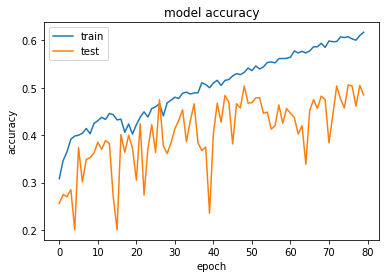

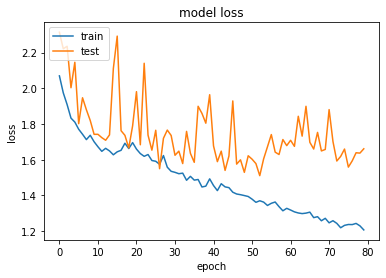

In [28]:
#def show_summary_stats(history):
    # List all data in history
print(h.history.keys())

    # Summarize history for accuracy
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('secuencial_acc-val_acc.jpg')
plt.show()

    # Summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig('secuencial_loss-val_loss.jpg')

plt.show()
    
    

# CNN-RNN en paralelo con GRU


Lin Feng, Shenlan Liu, Jianing Yao

https://arxiv.org/pdf/1712.08370.pdf

In [23]:
from keras import backend as K
from keras import regularizers
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau


# Clasificación categórica por genero

In [26]:
x_train_tids = df_train.index
x_valid_tids = df_valid.index
x_test_tids = df_test.index

y_train_labels = get_informacion(df_train)
y_valid_labels = get_informacion(df_valid)
y_test_labels = get_informacion(df_test)

BATCH_SIZE = 8

CANT_GENEROS = y_train_labels[1].shape[1]

NB_WORKER = mp.cpu_count()

INPUT_DIM = 3

params = {#'input_dim':INPUT_DIM,
          'batch_size':BATCH_SIZE,
          'shuffle':True,
          'nb_worker':NB_WORKER,
          'max_q_size':10}


#MMF
#aprovecho y reshapeo antes de alimentar el algoritmo!
#Para volver a abrir el dataset preprocesado hay que hacer:
npData_t_3D = np.memmap('x_train.dat', dtype='float32', mode='r', shape=(len(df_train), LONG_SPECTO, BINS, 1))  

npData_v_3D = np.memmap('x_valid.dat', dtype='float32', mode='r', shape=(len(df_valid), LONG_SPECTO, BINS, 1))  

npData_tst_3D = np.memmap('x_test.dat', dtype='float32', mode='r', shape=(len(df_test), LONG_SPECTO, BINS, 1))  

#Nota: mode='r' es solo lectura, mode='r+' es lectura escritura. 
#Nota 2: recorda hacer "del npData" para cerrar el archivo mapeado a memoria.


In [29]:
keras.backend.clear_session()

i = Input(shape=(LONG_SPECTO,BINS,1))


# Bloque Convolucional

c1 = Conv2D(16, kernel_size=(3,1), strides=1, padding='valid', activation='relu')(i)
p1 = MaxPooling2D((2,2), strides=(2,2))(c1)

c2 = Conv2D(32, kernel_size=(3,1), strides=1, padding='valid', activation='relu')(p1)
p2 = MaxPooling2D((2,2), strides=(2,2))(c2) 

c3 = Conv2D(64, kernel_size=(3,1), strides=1, padding='valid', activation='relu')(p2)
p3 = MaxPooling2D((2,2), strides=(2,2))(c3)

c4 = Conv2D(128, kernel_size=(3,1), strides=1, padding='valid', activation='relu')(p3)
p4 = MaxPooling2D((4,4), strides=(4,4))(c4) 

c5 = Conv2D(64, kernel_size=(3,1), strides=1, padding='valid', activation='relu')(p4)
p5 = MaxPooling2D((4,4), strides=(4,4))(c5)


f = Flatten()(p5) # esto deberia ser Output(256). BIEN


#Bloque recurrente - Bidireccional GRU 

pool_LSTM = MaxPooling2D(1,2)(i) #(1,2) strides (1,2) antes (4,2)

squeezed = Lambda(lambda x: K.squeeze(x, axis=-1))(pool_LSTM) #embedding

lstm = Bidirectional(GRU(80))(squeezed) #default merge mode is concat. deberia ser 128 para generar salida 256


#Concat output
concat = concatenate([f,lstm], axis=-1) #en original directamente a out

d = Dense(128, activation='relu')(concat)#, kernel_regularizer=regularizers.l2(0.01))(concat)
#dr = Dropout(0.3)(d) #al trabajar con frecuencias y tener poca precision, este dropout baja las canciones con proba debajo de .3

#Softmax output

out = Dense(CANT_GENEROS, activation='softmax')(d) 


model = Model(outputs=out,inputs=i)
#model = Secuential(model_input, model_output)

model.summary()


#como hay algunos generos parecidos, calculo el top k=3 accuracy

import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

#por ej: internacional puede ser rock, pop, folk, etc..

model.compile(loss='categorical_crossentropy', 
              optimizer=RMSprop(lr=0.001), #probar con opt=Adam 
              metrics=['accuracy',top3_acc])#'top_k_categorical_accuracy']) #buscar mas metricas


checkpoint_callback = ModelCheckpoint('./mejores_pesos.h5', monitor='val_acc', verbose=1,
                                          save_best_only=True, mode='max')
    
reducelr_callback = ReduceLROnPlateau(monitor='val_acc', factor=0.5, patience=10, min_delta=0.01)

callbacks = [checkpoint_callback, reducelr_callback]


h = model.fit(npData_t_3D, y_train_labels[1], batch_size=BATCH_SIZE, 
              epochs=100, verbose=1, validation_data=(npData_v_3D,y_valid_labels[1]), 
              shuffle=True)



__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 640, 128, 1)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 638, 128, 16) 64          input_1[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 319, 64, 16)  0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 317, 64, 32)  1568        max_pooling2d_1[0][0]            
__________________________________________________________________________________________________
max_poolin

6394/6394 [==============================] - 304s 48ms/step - loss: 1.8667 - acc: 0.2936 - top3_acc: 0.6289 - val_loss: 1.8263 - val_acc: 0.2650 - val_top3_acc: 0.6713
Epoch 24/50
6394/6394 [==============================] - 303s 47ms/step - loss: 1.8557 - acc: 0.2967 - top3_acc: 0.6332 - val_loss: 1.8300 - val_acc: 0.3000 - val_top3_acc: 0.6288
Epoch 25/50
6394/6394 [==============================] - 267s 42ms/step - loss: 1.8481 - acc: 0.3031 - top3_acc: 0.6351 - val_loss: 1.8641 - val_acc: 0.3137 - val_top3_acc: 0.6412
Epoch 26/50
6394/6394 [==============================] - 263s 41ms/step - loss: 1.8394 - acc: 0.3039 - top3_acc: 0.6425 - val_loss: 1.8682 - val_acc: 0.3187 - val_top3_acc: 0.6388
Epoch 27/50
6394/6394 [==============================] - 263s 41ms/step - loss: 1.8375 - acc: 0.3022 - top3_acc: 0.6442 - val_loss: 1.9332 - val_acc: 0.2900 - val_top3_acc: 0.6075
Epoch 28/50
6394/6394 [==============================] - 265s 41ms/step - loss: 1.8451 - acc: 0.3015 - top3_acc:

In [34]:
#loss = model.evaluate_generator(validation_data=npData_t_3D)
#loss = model.evaluate_generator(npData_v_3D, npData_v_3D.shape[0])
#Y = model.predict_generator(loader, test.size, pickle_safe=True, nb_worker=NB_WORKER, max_q_size=5)
model.evaluate(x=npData_tst_3D, y=y_test_labels, batch_size=BATCH_SIZE, 
               verbose=1, sample_weight=None, steps=None)#, callbacks=None)
#loss

#es al pedo hacer 100 epochs. el punto optimo de aprendizaje es 60 ciclos.
# con 60 epochs => val_loss: 1.8990 - val_acc: 0.2575 - val_top3_acc: 0.5887
#10 ciclos, acc=0.35

ValueError: Error when checking input: expected input_1 to have 3 dimensions, but got array with shape (800, 640, 128, 1)

In [ ]:
# RESULTADOS

#el dropout y regularizer camuflan los resultados finales. generan valores extremos

    
# GRU = 16 => tira, pero se queda corto.
    #val_loss: 1.9986 - val_acc: 0.2100 - val_top3_acc: 0.4963
    
    
# GRU(32) => esto no e' coca papi. Le da duro a la RAM. Mejora bastante la eficiencia
    #val_loss: 1.8000 - val_acc: 0.3375 - val_top3_acc: 0.6575
    #val_loss: 1.7752 - val_acc: 0.3237 - val_top3_acc: 0.6787

    
# GRU(64) => upa
    #val_loss=1.9202, val_acc=0.2988, top3=0.5938
    #val_loss=1.800,  val_acc=0.3175, top3=0.70      en 50 epochs    


#con GRU(80)   bazo. llega ~25 en acc, y aa ~55 en top3
    #

    
# con GRU(96)   medio poronga
    #1.8462860870361328, 0.27625, 0.667   en 40 epochs
    #2.076503037214279, 0.17375, 0.47  en 80 epochs

#segun paper
# con GRU(128) overfitting! empieza a subir la perdida
    #ya no sirve. se pasa y no aprende mas que un .20. por que?
    # loss=2.044, acc=0.225, top3=0.5112
    # loss=2.836, acc=0.318, top3=0.6387
    
      
#a medida que aumentas GRU(), mas es la precision de entrenamiento pero el error de la validacion es alto.

dict_keys(['val_loss', 'val_acc', 'val_top3_acc', 'loss', 'acc', 'top3_acc'])


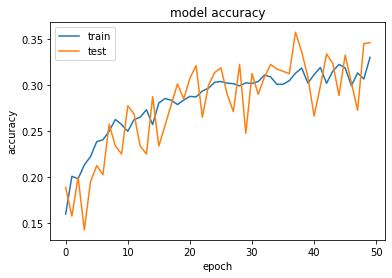

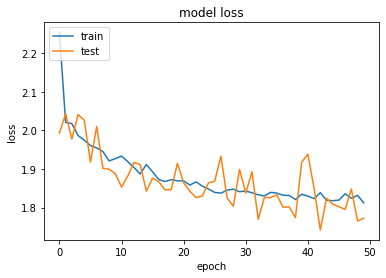

<Figure size 432x288 with 0 Axes>

In [35]:
print(h.history.keys())

# Summarize history for accuracy
plt.plot(h.history['acc'])
plt.plot(h.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Summarize history for loss
plt.plot(h.history['loss'])
plt.plot(h.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

plt.savefig('metricas.jpg')

In [36]:
dict_genres = {'Electronic':1, 'Experimental':2, 'Folk':3, 'Hip-Hop':4, 
               'Instrumental':5,'International':6, 'Pop' :7, 'Rock': 8  }

In [37]:
#model.save('music_genre.h5')
predicciones = model.predict(x=npData_tst_3D, batch_size=BATCH_SIZE)


ValueError: Error when checking input: expected input_1 to have 3 dimensions, but got array with shape (800, 640, 128, 1)

In [38]:
#preds = np.argmax(predicciones)
#predicciones[:5,:]   #head
predicciones[-5,:]   #tail

NameError: name 'predicciones' is not defined

In [39]:
#df_test.head()
df_test.tail()

set            track
         split subset genre_top
track_id                       
154305    test  small   Hip-Hop
154306    test  small   Hip-Hop
154307    test  small   Hip-Hop
154308    test  small   Hip-Hop
154309    test  small   Hip-Hop

In [40]:
# CONCLUSION parcial

# entrenando los modelos de forma secuencial se lograba una proyeccion (a partir de los 50 epochs) 
# del 50% de precision.
# al hacerlo en paralelo, entrena casi 4 veces mas rapido el 1er epoch pero la queda en un deadlock

In [41]:
from keras.utils.vis_utils import plot_model


In [42]:
from keras.utils import plot_model
plot_model(model, to_file='model.png')

OSError: `pydot` failed to call GraphViz.Please install GraphViz (https://www.graphviz.org/) and ensure that its executables are in the $PATH.

In [43]:
from keras.models import load_model

#model.save('genreRecognition.h5')  # creates a HDF5 file 'my_model.h5'
#del model

In [44]:
import functools
top3_acc = functools.partial(keras.metrics.top_k_categorical_accuracy, k=3)

top3_acc.__name__ = 'top3_acc'

#model = load_model('genreRecognition.h5', custom_objects={'top3_acc': top3_acc})

In [45]:
from sklearn.metrics import classification_report

y_true = y_test_labels[1]
decoded = np.empty(y_true.shape[0])

for i in range(y_true.shape[0]):
    datum = y_true[i]
    #print('index: %d' % i)
    #print('encoded datum: %s' % datum)
    decoded[i] = np.argmax(datum)
    #print('decoded datum: %s' % decoded)
    #print()
y_decoded = np.array(decoded)
print('y decodificado ',y_decoded)
#print(y_true)
x_test = npData_tst_3D
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)
labels = [0,1,2,3,4,5,6,7]
target_names = dict_genres.keys()

print(y_decoded.shape, y_pred.shape)
#print(classification_report(y_true, y_pred, target_names=target_names))

decoded datum: [7.00000000e+000 4.78106837e+151 9.12120674e+136 1.35301660e-023
 2.41317562e+185 1.06097870e-153 8.04430783e-095 2.87628886e+161
 8.09253585e+175 3.87653490e+228 2.65243281e+180 2.78108617e+180
 1.06024973e-153 4.42674758e+175 1.91190370e+214 1.31077751e+179
 2.50252131e+262 3.93850590e+180 1.06097755e-153 7.87400198e+199
 4.76862580e+180 1.99640162e+161 8.88780783e+252 6.77023535e+223
 2.87504628e+161 5.50026222e+247 1.06025488e-153 7.13172123e+247
 4.88814570e+199 6.99196216e+228 1.11789341e+253 1.61410559e+132
 1.42137876e-076 1.00385544e+218 1.46935426e+136 9.02193423e+217
 6.01347002e-154 6.01347002e-154 6.01347002e-154 6.01347002e-154
 1.61410559e+132 1.50763232e+161 1.61410559e+132 9.89803615e+164
 1.03307688e+136 9.02193423e+217 1.61410559e+132 8.83453808e+199
 9.89803615e+164 9.16281387e-072 1.09378592e-094 9.45956265e-076
 1.61410559e+132 2.95164085e-075 2.13412571e+257 6.60925411e-062
 9.89803615e+164 9.16281387e-072 2.13446945e+257 6.60925411e-062
 1.0370034

decoded datum: [7.00000000e+000 5.00000000e+000 5.00000000e+000 5.00000000e+000
 5.00000000e+000 5.00000000e+000 5.00000000e+000 2.00000000e+000
 2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 7.00000000e+000
 7.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 6.99196216e+228 1.11789341e+253 1.61410559e+132
 1.42137876e-076 1.00385544e+218 1.46935426e+136 9.02193423e+217
 6.01347002e-154 6.01347002e-154 6.01347002e-154 6.01347002e-154
 1.61410559e+132 1.50763232e+161 1.61410559e+132 9.89803615e+164
 1.03307688e+136 9.02193423e+217 1.61410559e+132 8.83453808e+199
 9.89803615e+164 9.16281387e-072 1.09378592e-094 9.45956265e-076
 1.61410559e+132 2.95164085e-075 2.13412571e+257 6.60925411e-062
 9.89803615e+164 9.16281387e-072 2.13446945e+257 6.60925411e-062
 1.0370034

decoded datum: [7.00000000e+000 5.00000000e+000 5.00000000e+000 5.00000000e+000
 5.00000000e+000 5.00000000e+000 5.00000000e+000 2.00000000e+000
 2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 7.00000000e+000
 7.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 4.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 9.16281387e-072 2.13446945e+257 6.60925411e-062
 1.0370034

decoded datum: [7.00000000e+000 5.00000000e+000 5.00000000e+000 5.00000000e+000
 5.00000000e+000 5.00000000e+000 5.00000000e+000 2.00000000e+000
 2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 7.00000000e+000
 7.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 4.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 1.00000000e+000
 1.0000000

decoded datum: [7.00000000e+000 5.00000000e+000 5.00000000e+000 5.00000000e+000
 5.00000000e+000 5.00000000e+000 5.00000000e+000 2.00000000e+000
 2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 7.00000000e+000
 7.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 4.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 1.00000000e+000
 1.0000000

decoded datum: [7.00000000e+000 5.00000000e+000 5.00000000e+000 5.00000000e+000
 5.00000000e+000 5.00000000e+000 5.00000000e+000 2.00000000e+000
 2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 7.00000000e+000
 7.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 4.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 1.00000000e+000
 1.0000000

decoded datum: [7.00000000e+000 5.00000000e+000 5.00000000e+000 5.00000000e+000
 5.00000000e+000 5.00000000e+000 5.00000000e+000 2.00000000e+000
 2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 7.00000000e+000
 7.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 4.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 1.00000000e+000
 1.0000000

decoded datum: [7.00000000e+000 5.00000000e+000 5.00000000e+000 5.00000000e+000
 5.00000000e+000 5.00000000e+000 5.00000000e+000 2.00000000e+000
 2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 7.00000000e+000
 7.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 4.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 1.00000000e+000
 1.0000000

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)




decoded datum: [7.00000000e+000 5.00000000e+000 5.00000000e+000 5.00000000e+000
 5.00000000e+000 5.00000000e+000 5.00000000e+000 2.00000000e+000
 2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 7.00000000e+000
 7.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 4.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 1.00000000e+000
 1.000000

decoded datum: [7.00000000e+000 5.00000000e+000 5.00000000e+000 5.00000000e+000
 5.00000000e+000 5.00000000e+000 5.00000000e+000 2.00000000e+000
 2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 7.00000000e+000
 7.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 4.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 1.00000000e+000
 1.0000000

decoded datum: [7.00000000e+000 5.00000000e+000 5.00000000e+000 5.00000000e+000
 5.00000000e+000 5.00000000e+000 5.00000000e+000 2.00000000e+000
 2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 7.00000000e+000
 7.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 4.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 1.00000000e+000
 1.0000000

decoded datum: [7.00000000e+000 5.00000000e+000 5.00000000e+000 5.00000000e+000
 5.00000000e+000 5.00000000e+000 5.00000000e+000 2.00000000e+000
 2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 7.00000000e+000
 7.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 4.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 1.00000000e+000
 1.0000000

decoded datum: [7.00000000e+000 5.00000000e+000 5.00000000e+000 5.00000000e+000
 5.00000000e+000 5.00000000e+000 5.00000000e+000 2.00000000e+000
 2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 7.00000000e+000
 7.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 4.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 1.00000000e+000
 1.0000000

decoded datum: [7.00000000e+000 5.00000000e+000 5.00000000e+000 5.00000000e+000
 5.00000000e+000 5.00000000e+000 5.00000000e+000 2.00000000e+000
 2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 7.00000000e+000
 7.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 4.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 1.00000000e+000
 1.0000000

decoded datum: [7.00000000e+000 5.00000000e+000 5.00000000e+000 5.00000000e+000
 5.00000000e+000 5.00000000e+000 5.00000000e+000 2.00000000e+000
 2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 7.00000000e+000
 7.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 4.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 1.00000000e+000
 1.0000000

decoded datum: [7.00000000e+000 5.00000000e+000 5.00000000e+000 5.00000000e+000
 5.00000000e+000 5.00000000e+000 5.00000000e+000 2.00000000e+000
 2.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 7.00000000e+000
 7.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 1.00000000e+000 1.00000000e+000 1.00000000e+000 1.00000000e+000
 4.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 2.00000000e+000
 2.00000000e+000 2.00000000e+000 2.00000000e+000 1.00000000e+000
 1.0000000

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns


mat = confusion_matrix(y_decoded, y_pred)
sns.heatmap(mat.T, square=True, annot=True, fmt='d', cbar=False,
            xticklabels=dict_genres.keys(),
            yticklabels=dict_genres.keys())
plt.xlabel('true label')
plt.ylabel('predicted label')
plt.savefig('matriz_confusion.jpg')

ModuleNotFoundError: No module named 'seaborn'

# Generacion de musica con Redes Neuronales

In [ ]:
# con LSTM, la idea es generar un fragmento de musica a partir de las redes neuronales entrenadas.
# por otra parte, probar una red generativa alimentada con canciones como generador y discriminante
# y ver resultados de la prediccion

# Generative adversarial neural networks

In [ ]:
#https://medium.com/neuronio/audio-generation-with-gans-428bc2de5a89